In [6]:
!pip install qutip
!pip install cma

In [126]:
# Import python libraries

from qutip import *
import cma
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [127]:
result_g = qload('result_g_ideal_lowk')
result_e = qload('result_e_ideal_lowk')
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

In [128]:
def readout_fidelity(start_time, end_time):
  start_time = int(np.ceil(start_time))
  end_time = int(np.ceil(end_time))

  I_g = list()
  Q_g = list()
  I_e = list()
  Q_e = list()

  if start_time >= end_time:
    return -np.inf,-np.inf
  else:
    for m in result_g.measurement:
        I = m[0, 0, start_time:end_time]
        Q = m[0, 1, start_time:end_time]
        I_int = np.sum(I) * dt
        Q_int = np.sum(Q) * dt
        I_g.append(I_int)
        Q_g.append(Q_int)

    for m in result_e.measurement:
        I = m[0, 0, start_time:end_time]
        Q = m[0, 1, start_time:end_time]
        I_int = np.sum(I) * dt
        Q_int = np.sum(Q) * dt
        I_e.append(I_int)
        Q_e.append(Q_int)

    IQ_g = np.vstack([I_g, Q_g]).T
    IQ_e = np.vstack([I_e, Q_e]).T

    # Stack all IQs and labels
    IQ_all = np.vstack([IQ_g, IQ_e])
    labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

    # Train LDA
    lda = LinearDiscriminantAnalysis()
    try:
      lda.fit(IQ_all.real, labels)
    except IndexError as E:
      print("Index Error:", start_time, end_time)
    preds = lda.predict(IQ_all.real)

    coef = lda.coef_[0]      # [w1, w2]
    intercept = lda.intercept_[0]  # w0

    w1, w2 = coef
    y_vals = -(intercept + w1 * IQ_all) / w2

    # Readout fidelity
    fidelity = accuracy_score(labels, preds)

    # Mean vectors
    mu_g = np.mean(IQ_g, axis=0)
    mu_e = np.mean(IQ_e, axis=0)

    # Difference vector (signal direction)
    d = mu_e - mu_g
    d_unit = d / np.linalg.norm(d)

    # Project all IQ points onto signal axis
    proj_g = IQ_g @ d_unit
    proj_e = IQ_e @ d_unit

    # Compute noise variance (assume equal noise for both classes)
    sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

    # Compute SNR
    snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2

    return fidelity, snr


In [129]:
# === Your Cost Function ===
def readout_cost(params):
    fidelity, snr = readout_fidelity(*params)
    print(f"Params: {params} → Fiedlity: {fidelity}, SNR: {snr}")
    return -fidelity

# === Parameter Bounds ===
bounds = [(1, 7999),      # Integration start time
          (2, 8000),      # Integration end time
          ]

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(readout_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best integration times:", res.result.xbest)
print("Best readout fidelity:", -res.result.fbest)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=912107, Fri Jun 13 06:33:00 2025)
Params: [3580.38656156 4133.11558566] → Fiedlity: 0.56, SNR: 0.014158231668878926
Params: [4377.56587058 4194.18498767] → Fiedlity: -inf, SNR: -inf
Params: [3588.38178355 3891.49959389] → Fiedlity: 0.53, SNR: 0.05997175579169154
Params: [3925.00033301 4194.42336551] → Fiedlity: 0.65, SNR: 0.17539327731683269
Params: [4203.16751861 4092.25883375] → Fiedlity: -inf, SNR: -inf
Params: [4098.00388054 4015.25518814] → Fiedlity: -inf, SNR: -inf
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.500000000000000e-01 1.0e+00 3.08e-01  2e+02  3e+02 0:00.0
Params: [3360.70714988 4417.60801079] → Fiedlity: 0.49, SNR: 0.03256999545855855
Params: [4121.84929763 3577.20785472] → Fiedlity: -inf, SNR: -inf
Params: [3778.5264465  4346.48658456] → Fiedlity: 0.55, SNR: 0.012351325897730078
Params: [3381.26240944 4779.97453035] → Fiedlity: 0.58, SNR: 0.16138452230005548
Params: [388

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 4, 5] are not finite but [inf, inf, inf]. (time=Jun 13 06:33:01 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 5] are not finite but [inf, inf]. (time=Jun 13 06:33:01 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_mi

Params: [4790.44525674 7873.95574498] → Fiedlity: 0.72, SNR: 1.5026615350714476
Params: [3875.3195423  6369.40894444] → Fiedlity: 0.66, SNR: 1.128342583055995
Params: [7319.30386994 7050.17884119] → Fiedlity: -inf, SNR: -inf
    9     54 -7.200000000000000e-01 2.0e+00 1.57e+00  8e+02  1e+03 0:00.2
Params: [5970.32183712 7727.45680576] → Fiedlity: 0.73, SNR: 1.298857126199551
Params: [7303.55866066 6047.97102842] → Fiedlity: -inf, SNR: -inf
Params: [5456.88206279 6860.07119659] → Fiedlity: 0.71, SNR: 1.2254857530034395
Params: [5553.98682917 5780.6022322 ] → Fiedlity: 0.56, SNR: 0.43320004132267503
Params: [6295.92334477 7988.84195675] → Fiedlity: 0.73, SNR: 0.8370545627076271
Params: [5299.46564926 7462.29738879] → Fiedlity: 0.75, SNR: 1.5043382888867016
   10     60 -7.500000000000000e-01 1.9e+00 1.46e+00  7e+02  1e+03 0:00.2
Params: [5161.54205845 6634.40754207] → Fiedlity: 0.74, SNR: 1.5064758714761435
Params: [5214.342686   7480.79190999] → Fiedlity: 0.77, SNR: 1.5029390412428745
P

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [5] are not finite but [inf]. (time=Jun 13 06:33:01 2025 class=CMAEvolutionStrategy method=ask iteration=8)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1] are not finite but [inf]. (time=Jun 13 06:33:01 2025 class=CMAEvolutionStrategy method=ask iteration=9)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/loc

Params: [4777.84497322 6455.39613857] → Fiedlity: 0.68, SNR: 1.1695669005305727
Params: [5559.40339886 6275.3432925 ] → Fiedlity: 0.68, SNR: 0.6835254957892589
Params: [4357.60366061 6921.78996215] → Fiedlity: 0.72, SNR: 1.8531069187420954
Params: [4841.41790439 5953.75716997] → Fiedlity: 0.59, SNR: 0.643795212391659
Params: [4969.00898223 6780.9681047 ] → Fiedlity: 0.71, SNR: 1.5594636774989423
Params: [4782.06317802 6931.29061417] → Fiedlity: 0.71, SNR: 1.46636860586712
   15     90 -7.200000000000000e-01 1.9e+00 1.19e+00  4e+02  6e+02 0:00.4
Params: [4599.66840775 6443.32130357] → Fiedlity: 0.7, SNR: 1.3187104470097093
Params: [4556.06809682 5597.79604526] → Fiedlity: 0.72, SNR: 0.6847168741058548
Params: [5207.20308879 7115.8111234 ] → Fiedlity: 0.78, SNR: 1.8303531244383124
Params: [4488.89348841 6763.79932979] → Fiedlity: 0.68, SNR: 1.533930073054722
Params: [4644.68074045 7324.07843836] → Fiedlity: 0.7, SNR: 1.4864564463218113
Params: [4378.45043879 7868.8610227 ] → Fiedlity: 0.

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5350.49504065 7970.60097852] → Fiedlity: 0.73, SNR: 1.5757193888347996
Params: [4911.51034661 7939.3425307 ] → Fiedlity: 0.72, SNR: 1.6104879129028178
Params: [5564.08274901 7709.89817789] → Fiedlity: 0.71, SNR: 1.347546859324814
Params: [6200.76465521 7085.11572718] → Fiedlity: 0.72, SNR: 0.9013026566228346
   22    132 -7.400000000000000e-01 2.7e+00 1.35e+00  2e+02  7e+02 0:00.6
Params: [5135.6978321  7964.86157286] → Fiedlity: 0.77, SNR: 1.7105458740759547
Params: [4724.56772217 7987.30329874] → Fiedlity: 0.73, SNR: 1.639952545460829
Params: [5137.2396356  7991.00998031] → Fiedlity: 0.76, SNR: 1.780811215281914
Params: [4736.31512214 7995.00856854] → Fiedlity: 0.7, SNR: 1.6170699833661701
Params: [5486.38891322 7983.57528215] → Fiedlity: 0.73, SNR: 1.4061651823081678
Params: [5219.28867394 7761.15201524] → Fiedlity: 0.78, SNR: 1.7122565834974297
   23    138 -7.800000000000000e-01 3.1e+00 1.62e+00  2e+02  1e+03 0:00.7
Params: [5073.72408976 7237.07957856] → Fiedlity: 0.74, 

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

   27    162 -7.700000000000000e-01 6.2e+00 1.20e+00  1e+02  7e+02 0:00.8
Params: [4852.41739419 7039.23841546] → Fiedlity: 0.71, SNR: 1.475952205724289
Params: [5312.2262928  7998.61820797] → Fiedlity: 0.74, SNR: 1.5679978678243278
Params: [5322.50907545 7232.7626468 ] → Fiedlity: 0.7, SNR: 1.7390696731161936
Params: [5297.95615691 7840.69678074] → Fiedlity: 0.77, SNR: 1.5580676057822638
Params: [5313.09648841 7570.31479585] → Fiedlity: 0.77, SNR: 1.6245906929591523
Params: [5275.81139835 6844.19233552] → Fiedlity: 0.74, SNR: 1.3217252649707871
   28    168 -7.700000000000000e-01 6.1e+00 1.51e+00  2e+02  9e+02 0:00.9
Params: [5272.73966623 7980.96024516] → Fiedlity: 0.75, SNR: 1.5123921690507933
Params: [5237.58717704 7895.4816362 ] → Fiedlity: 0.77, SNR: 1.4785463191734762
Params: [5174.64332048 7926.57116812] → Fiedlity: 0.75, SNR: 1.5414267944259141
Params: [5252.40787125 6897.06064921] → Fiedlity: 0.75, SNR: 1.5052379981458262
Params: [5001.31207742 7761.83802339] → Fiedlity: 0.75

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [4935.85351413 7608.43445198] → Fiedlity: 0.76, SNR: 1.6957528721369484
Params: [5288.23998236 7859.5860168 ] → Fiedlity: 0.75, SNR: 1.58976878883567
Params: [5209.37379177 6895.29539859] → Fiedlity: 0.76, SNR: 1.6772154083187933
Params: [5078.72926076 6475.99396662] → Fiedlity: 0.75, SNR: 1.3775249819964184
Params: [5180.76227651 7894.90568749] → Fiedlity: 0.76, SNR: 1.547319055574277
Params: [5094.16866744 6315.85847212] → Fiedlity: 0.75, SNR: 1.3971477126673773
   32    192 -7.600000000000000e-01 7.4e+00 1.68e+00  2e+02  8e+02 0:01.0
Params: [4892.78055963 6877.29399572] → Fiedlity: 0.72, SNR: 1.4817888114129703
Params: [4967.1283666  7393.85535681] → Fiedlity: 0.73, SNR: 1.5501350894270396
Params: [4792.25878505 7563.41222326] → Fiedlity: 0.73, SNR: 1.452731413113457
Params: [5081.73417601 7990.92515482] → Fiedlity: 0.76, SNR: 1.8231504466236614
Params: [4693.05564052 7094.75090295] → Fiedlity: 0.71, SNR: 1.6293924552775512
Params: [4976.4409787  7583.99573401] → Fiedlity: 

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Params: [5031.96166803 7411.9412303 ] → Fiedlity: 0.71, SNR: 1.5720959305091997
Params: [4776.04027253 7829.85868895] → Fiedlity: 0.73, SNR: 1.5227790255140687
   36    216 -7.500000000000000e-01 6.8e+00 1.07e+00  7e+01  4e+02 0:01.2
Params: [5078.42448999 7704.85031833] → Fiedlity: 0.74, SNR: 1.7889294998059733
Params: [4986.70863181 7999.97525144] → Fiedlity: 0.75, SNR: 1.676785205042429
Params: [5017.43976407 7998.68417552] → Fiedlity: 0.74, SNR: 1.7407654061704865
Params: [4936.39519896 7683.57615305] → Fiedlity: 0.72, SNR: 1.660633534402931
Params: [5083.82860224 7984.40452756] → Fiedlity: 0.77, SNR: 1.8168728626761528
Params: [5146.80149326 7850.94215932] → Fiedlity: 0.8, SNR: 1.7067295914653307
   37    222 -8.000000000000000e-01 6.6e+00 1.11e+00  7e+01  4e+02 0:01.3
Params: [4910.92982487 7733.94061757] → Fiedlity: 0.74, SNR: 1.7878961319515396
Params: [5074.25920279 7973.41080335] → Fiedlity: 0.76, SNR: 1.7714244322548236
Params: [5217.46239753 7998.39420972] → Fiedlity: 0.77,

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5286.79754094 7186.46057645] → Fiedlity: 0.73, SNR: 1.6556027620774576
Params: [5310.39739164 7020.31571481] → Fiedlity: 0.74, SNR: 1.5995155769045177
Params: [5262.64717709 7876.38421901] → Fiedlity: 0.74, SNR: 1.4852978768209595
Params: [5422.92499161 6061.13227382] → Fiedlity: 0.62, SNR: 0.566133286246509
Params: [5254.10531065 7608.98784164] → Fiedlity: 0.78, SNR: 1.6229256668389045
Params: [5307.31022682 7707.35514969] → Fiedlity: 0.75, SNR: 1.627999463711719
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   41    246 -7.800000000000000e-01 4.5e+00 1.29e+00  1e+02  3e+02 0:01.4
Params: [5297.37908955 7748.41709155] → Fiedlity: 0.77, SNR: 1.6828882064211474
Params: [5337.80244635 6960.32567635] → Fiedlity: 0.73, SNR: 1.6701448472894898
Params: [5318.2602434  7540.04240067] → Fiedlity: 0.76, SNR: 1.5659179758881945
Params: [5215.62747985 7919.55998285] → Fiedlity: 0.75, SNR: 1.5744071057949132
Params: [5332.69176983 7376.64941258] → Fiedlity: 0.72, 

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5156.20829355 7619.54250153] → Fiedlity: 0.78, SNR: 1.797924434667803
   46    276 -7.800000000000000e-01 1.9e+00 7.21e-01  5e+01  8e+01 0:01.6
Params: [5145.47617651 7565.36298421] → Fiedlity: 0.76, SNR: 1.7259286855512321
Params: [5150.93747306 7737.40885953] → Fiedlity: 0.76, SNR: 1.8333092293117466
Params: [5189.34535882 7632.26752708] → Fiedlity: 0.79, SNR: 1.7610967118550924
Params: [5236.97337106 7564.15011079] → Fiedlity: 0.77, SNR: 1.5508580039111044
Params: [5253.53067026 7698.18189783] → Fiedlity: 0.75, SNR: 1.5485058576994197
Params: [5155.71029339 7678.86343489] → Fiedlity: 0.77, SNR: 1.7696022251989652
   47    282 -7.900000000000000e-01 1.6e+00 5.92e-01  4e+01  6e+01 0:01.7
Params: [5270.56252915 7596.33219976] → Fiedlity: 0.79, SNR: 1.561405109079005
Params: [5169.0099281  7706.76081645] → Fiedlity: 0.76, SNR: 1.6748419474876457
Params: [5193.74311704 7581.25795298] → Fiedlity: 0.78, SNR: 1.7069610322456827
Params: [5227.11407879 7612.97532585] → Fiedlity: 0.77

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5065.55003123 7596.15636195] → Fiedlity: 0.77, SNR: 1.85791810731411
Params: [5195.71071705 7573.44668678] → Fiedlity: 0.77, SNR: 1.6377790641878114
Params: [5067.82568216 7610.29360927] → Fiedlity: 0.76, SNR: 1.8816468522380656
Params: [5176.47335076 7648.54560429] → Fiedlity: 0.79, SNR: 1.734081589521813
Params: [5036.54025528 7582.88988165] → Fiedlity: 0.76, SNR: 1.6965941637353663
Params: [5041.72106525 7672.51769822] → Fiedlity: 0.74, SNR: 1.7011337976358913
   52    312 -7.900000000000000e-01 1.3e+00 6.38e-01  4e+01  5e+01 0:01.9
Params: [5166.05891035 7555.75625896] → Fiedlity: 0.78, SNR: 1.5991869258196816
Params: [5100.12679072 7659.81227222] → Fiedlity: 0.79, SNR: 1.909119957481136
Params: [5267.965313  7683.2366046] → Fiedlity: 0.76, SNR: 1.584014288879874
Params: [5214.75963012 7620.75464581] → Fiedlity: 0.79, SNR: 1.7409509305226338
Params: [5158.40678043 7596.3869857 ] → Fiedlity: 0.81, SNR: 1.7528738091706886
Params: [5249.79070579 7612.52262978] → Fiedlity: 0.7

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5116.03136186 7542.66493321] → Fiedlity: 0.78, SNR: 1.7158949479911136
Params: [5117.19154665 7589.98922269] → Fiedlity: 0.81, SNR: 1.8656603654440755
Params: [5128.65991255 7596.56575304] → Fiedlity: 0.81, SNR: 1.8042174207082826
Params: [5186.41242357 7594.28816578] → Fiedlity: 0.8, SNR: 1.7154560903298672
Params: [5089.65625639 7630.87871003] → Fiedlity: 0.78, SNR: 1.9172882284367432
Params: [5129.16969129 7634.87854778] → Fiedlity: 0.78, SNR: 1.838720486770878
   57    342 -8.100000000000001e-01 1.4e+00 4.73e-01  2e+01  3e+01 0:02.1
Params: [5125.81999522 7610.08303046] → Fiedlity: 0.8, SNR: 1.8448596184371275
Params: [5076.86444484 7579.92050906] → Fiedlity: 0.78, SNR: 1.7638002329941194
Params: [5148.50416974 7572.17443437] → Fiedlity: 0.79, SNR: 1.6892731440832043
Params: [5102.49048946 7589.92121699] → Fiedlity: 0.81, SNR: 1.9123991868158519
Params: [5169.02762861 7611.96367479] → Fiedlity: 0.79, SNR: 1.7332151165507284
Params: [5148.05232571 7591.94256045] → Fiedlity:

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply


Params: [5125.85645803 7601.58947014] → Fiedlity: 0.81, SNR: 1.7924993856185725
Params: [5131.02098701 7592.31286029] → Fiedlity: 0.8, SNR: 1.7851819883029165
Params: [5141.32886253 7606.89702396] → Fiedlity: 0.8, SNR: 1.8693956946589116
Params: [5145.40575305 7592.59028591] → Fiedlity: 0.8, SNR: 1.8261611385633714
Params: [5121.22156069 7592.10751953] → Fiedlity: 0.8, SNR: 1.8375999983236084
   62    372 -8.100000000000001e-01 1.5e+00 1.64e-01  4e+00  5e+00 0:02.3
Params: [5134.23504835 7605.06080507] → Fiedlity: 0.78, SNR: 1.8541036334428462
Params: [5133.61143364 7598.01957917] → Fiedlity: 0.81, SNR: 1.841835791966548
Params: [5133.39161823 7606.79162304] → Fiedlity: 0.79, SNR: 1.8706761885022352
Params: [5139.25685504 7601.56785901] → Fiedlity: 0.79, SNR: 1.8240000370586078
Params: [5125.56090007 7597.93803789] → Fiedlity: 0.81, SNR: 1.7891005207505537
Params: [5140.49733486 7605.22332509] → Fiedlity: 0.77, SNR: 1.8654543591319364
   63    378 -8.100000000000001e-01 1.4e+00 1.49e-

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [5132.13686893 7598.06016206] → Fiedlity: 0.81, SNR: 1.822391631205635
Params: [5132.47027383 7596.01746457] → Fiedlity: 0.81, SNR: 1.8082754473327183
Params: [5131.95822023 7595.90882998] → Fiedlity: 0.81, SNR: 1.7883483884542724
Params: [5127.69428994 7594.05486941] → Fiedlity: 0.81, SNR: 1.827481356385682
Params: [5129.44453529 7595.22298427] → Fiedlity: 0.81, SNR: 1.7888816447894542
Params: [5129.63103931 7595.54870641] → Fiedlity: 0.81, SNR: 1.7888816447894542
   67    402 -8.100000000000001e-01 1.3e+00 9.61e-02  2e+00  2e+00 0:02.5
Best integration times: [5156.99343826 7601.68892932]
Best readout fidelity: 0.81


/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Readout fidelity (Qubit Relaxation): 0.8100
SNR of readout: 1.76


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


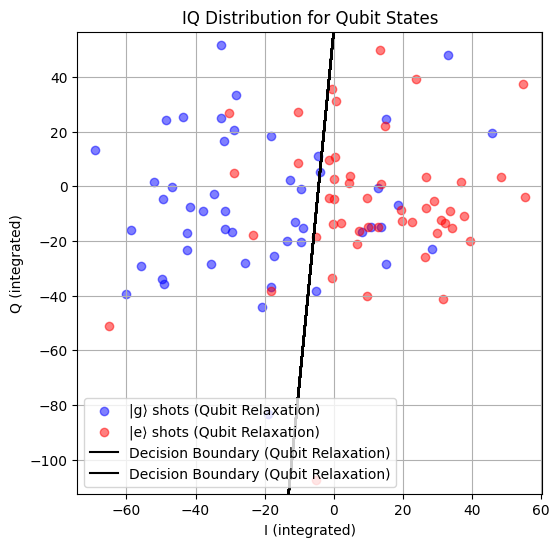

In [130]:
optimal_start_time = int(res.result.xbest[0])
optimal_end_time = int(res.result.xbest[1])

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(min(Q_g + Q_e) - 5,max(Q_g + Q_e) + 5)
plt.xlim(min(I_g + I_e) - 5,max(I_g + I_e) + 5)
plt.show()

In [131]:
result_g = qload('result_g_ideal_highk')
result_e = qload('result_e_ideal_highk')

In [132]:
# === Your Cost Function ===
def readout_cost(params):
    fidelity, snr = readout_fidelity(*params)
    print(f"Params: {params} → Fiedlity: {fidelity}, SNR: {snr}")
    return -fidelity

# === Parameter Bounds ===
bounds = [(1, 7999),      # Integration start time
          (2, 8000),      # Integration end time
          ]

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(readout_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best integration times:", res.result.xbest)
print("Best readout fidelity:", -res.result.fbest)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=857520, Fri Jun 13 06:33:04 2025)
Params: [4067.71265018 4023.22521771] → Fiedlity: -inf, SNR: -inf
Params: [3831.95527927 4163.23623219] → Fiedlity: 0.6, SNR: 0.10463576846450218
Params: [3504.78549668 4366.68919586] → Fiedlity: 0.54, SNR: 0.016680086342261598
Params: [4325.40890906 3761.7219709 ] → Fiedlity: -inf, SNR: -inf
Params: [3958.61422302 3687.36942903] → Fiedlity: -inf, SNR: -inf
Params: [3591.31991332 3866.91587179] → Fiedlity: 0.63, SNR: 0.18880419200896162
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -6.300000000000000e-01 1.0e+00 3.58e-01  2e+02  4e+02 0:00.0
Params: [3662.88825089 4038.03242904] → Fiedlity: 0.55, SNR: 0.07536443622736484
Params: [3954.44218447 4515.39672149] → Fiedlity: 0.59, SNR: 0.19799734044718126
Params: [3072.3011511  3823.49046153] → Fiedlity: 0.6, SNR: 0.1916829675954505
Params: [4494.5179687 3936.5456394] → Fiedlity: -inf, SNR: -inf
Params: [3161.4438

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 3, 4] are not finite but [inf, inf, inf]. (time=Jun 13 06:33:04 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [3] are not finite but [inf]. (time=Jun 13 06:33:04 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr

Params: [3670.50040589 3947.18088003] → Fiedlity: 0.5, SNR: 0.04609276928339945
Params: [3799.6155757  4098.06785843] → Fiedlity: 0.55, SNR: 0.10357782325468254
Params: [3632.3925498  3734.81309009] → Fiedlity: 0.52, SNR: 0.03626703007907671
    8     48 -6.000000000000000e-01 1.7e+00 2.47e-01  1e+02  2e+02 0:00.2
Params: [3793.73235562 3982.35294588] → Fiedlity: 0.54, SNR: 0.08638767513731274
Params: [3406.18176051 4000.39859828] → Fiedlity: 0.51, SNR: 0.0030128563341426475
Params: [3738.70685597 3784.73794889] → Fiedlity: 0.6, SNR: 0.20169469701093962
Params: [3610.78117265 3787.14217167] → Fiedlity: 0.57, SNR: 0.15120962703977578
Params: [3834.31020103 4047.34639252] → Fiedlity: 0.61, SNR: 0.2728388296676825
Params: [3604.22169789 3872.62034934] → Fiedlity: 0.57, SNR: 0.15000389311467058
    9     54 -6.100000000000000e-01 1.5e+00 1.94e-01  1e+02  1e+02 0:00.2
Params: [3929.88888944 4029.5460394 ] → Fiedlity: 0.61, SNR: 0.23586908731241832
Params: [3748.71093142 4064.5355091 ] → Fie

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0] are not finite but [

Params: [3872.22436969 4244.68899874] → Fiedlity: 0.58, SNR: 0.18960507386061334
Params: [3497.21284762 3899.17617486] → Fiedlity: 0.54, SNR: 0.14419536756798168
Params: [3484.93669007 3745.03785244] → Fiedlity: 0.54, SNR: 0.09574100545083904
Params: [3897.3874311  4046.34944026] → Fiedlity: 0.64, SNR: 0.45516369047750044
Params: [3239.05416348 3692.85275442] → Fiedlity: 0.55, SNR: 0.04636691195979095
Params: [3657.34640415 3836.02784482] → Fiedlity: 0.52, SNR: 0.1340522190313517
   14     84 -6.400000000000000e-01 2.6e+00 2.41e-01  2e+02  2e+02 0:00.4
Params: [3810.72332434 4154.46352808] → Fiedlity: 0.54, SNR: 0.07151546396657925
Params: [3934.0907833 4082.9869338] → Fiedlity: 0.53, SNR: 0.07619038004848326
Params: [3653.53355633 3905.93832949] → Fiedlity: 0.57, SNR: 0.12194235637505069
Params: [3836.45384744 4205.10151554] → Fiedlity: 0.56, SNR: 0.13791529657606572
Params: [3788.60472331 4082.82889175] → Fiedlity: 0.53, SNR: 0.1089022968815068
Params: [4232.02973285 4577.58968379] →

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0] are not finite but [inf]. (time=Jun 13 06:33:04 2025 class=CMAEvolutionStrategy method=ask iteration=15)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: U

Params: [4817.50648554 5169.27914737] → Fiedlity: 0.52, SNR: 0.057523212336224476
Params: [3963.90584848 4405.03826711] → Fiedlity: 0.58, SNR: 0.12778035986955122
Params: [3653.68660594 4078.08670386] → Fiedlity: 0.49, SNR: 0.02201436186766956
Params: [3542.45331038 3977.20960466] → Fiedlity: 0.53, SNR: 0.009555713984454917
Params: [3596.98934781 4133.2971452 ] → Fiedlity: 0.56, SNR: 0.008673067401678768
Params: [3364.92277265 4082.85151288] → Fiedlity: 0.55, SNR: 0.014483842519698146
   20    120 -5.800000000000000e-01 4.0e+00 4.50e-01  3e+02  3e+02 0:00.7
Params: [3797.03007658 4351.79566732] → Fiedlity: 0.59, SNR: 0.15864642000490797
Params: [3630.54814713 4243.04347825] → Fiedlity: 0.52, SNR: 0.007830188440795407
Params: [4050.40425152 4544.97091581] → Fiedlity: 0.57, SNR: 0.05476019951423085
Params: [4333.4325459  4799.23410967] → Fiedlity: 0.51, SNR: 0.009989304321519848
Params: [3995.55724366 4381.92131383] → Fiedlity: 0.55, SNR: 0.06188259730239586
Params: [4340.33870038 4369.7

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3922.15324072 4443.61440836] → Fiedlity: 0.65, SNR: 0.2545314211872556
Params: [3864.71905981 4423.03336513] → Fiedlity: 0.66, SNR: 0.3052086701352344
Params: [3844.93689932 4447.91086122] → Fiedlity: 0.66, SNR: 0.3423973658354225
Params: [3996.23485809 4483.71445533] → Fiedlity: 0.58, SNR: 0.1994396138015594
   26    156 -6.600000000000000e-01 3.6e+00 2.45e-01  1e+02  1e+02 0:00.9
Params: [3804.75290205 4424.32237743] → Fiedlity: 0.63, SNR: 0.24120732481554358
Params: [3702.85144951 4321.86299646] → Fiedlity: 0.57, SNR: 0.07565487793017676
Params: [4031.62730246 4544.44639931] → Fiedlity: 0.57, SNR: 0.048669468933841234
Params: [3884.15975922 4372.97623044] → Fiedlity: 0.62, SNR: 0.31017824946938427
Params: [3738.63260362 4303.70834568] → Fiedlity: 0.57, SNR: 0.0653764499475551
Params: [3877.45128409 4384.23453518] → Fiedlity: 0.63, SNR: 0.25949156374576515
   27    162 -6.300000000000000e-01 2.8e+00 2.33e-01  8e+01  8e+01 0:00.9
Params: [3976.30648375 4481.27526262] → Fiedli

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3825.90283496 4427.63351077] → Fiedlity: 0.64, SNR: 0.3184918791281038
Params: [3813.38100904 4428.60227976] → Fiedlity: 0.6, SNR: 0.2627529438714744
Params: [3865.17791674 4466.15716501] → Fiedlity: 0.63, SNR: 0.39904239141770753
Params: [3825.9891232  4465.12842519] → Fiedlity: 0.66, SNR: 0.40548420819237313
Params: [3858.7549075  4468.54870143] → Fiedlity: 0.66, SNR: 0.3953510001501207
   33    198 -6.600000000000000e-01 1.3e+00 9.72e-02  1e+01  2e+01 0:01.1
Params: [3841.69133382 4463.41502422] → Fiedlity: 0.67, SNR: 0.3787224853675732
Params: [3868.62613089 4469.22278281] → Fiedlity: 0.63, SNR: 0.4021193229279638
Params: [3852.57236863 4471.04074807] → Fiedlity: 0.63, SNR: 0.3725740675750992
Params: [3854.50491761 4467.25675906] → Fiedlity: 0.65, SNR: 0.3995338240397202
Params: [3837.67481376 4470.4976639 ] → Fiedlity: 0.62, SNR: 0.3395365362513137
Params: [3860.15442045 4456.89882897] → Fiedlity: 0.66, SNR: 0.39148632095768926
   34    204 -6.700000000000000e-01 1.4e+00 

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3824.89322709 4430.96411474] → Fiedlity: 0.65, SNR: 0.30141823562668735
Params: [3827.17125879 4432.72196631] → Fiedlity: 0.69, SNR: 0.3166528516992904
Params: [3833.00765688 4431.84389191] → Fiedlity: 0.65, SNR: 0.2989425292006081
Params: [3815.18505291 4433.17544777] → Fiedlity: 0.64, SNR: 0.284439748494302
   40    240 -6.899999999999999e-01 1.1e+00 7.84e-02  1e+01  1e+01 0:01.3
Params: [3852.5977719  4432.07814119] → Fiedlity: 0.64, SNR: 0.3590585294815273
Params: [3830.37376642 4439.08018733] → Fiedlity: 0.63, SNR: 0.3552046368119969
Params: [3839.2679259  4433.90787889] → Fiedlity: 0.65, SNR: 0.3227676270876486
Params: [3814.88594958 4445.40765474] → Fiedlity: 0.67, SNR: 0.3571687507257093
Params: [3842.47248335 4426.54718035] → Fiedlity: 0.65, SNR: 0.30639321643921613
Params: [3835.05553752 4441.74070038] → Fiedlity: 0.63, SNR: 0.3778336712144493
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   41    246 -6.700000000000000e-01 1.1e+00 6.40e-02 

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

   46    276 -6.800000000000000e-01 1.3e+00 2.84e-02  2e+00  3e+00 0:01.4
Params: [3826.26898139 4436.96291161] → Fiedlity: 0.69, SNR: 0.346694385419356
Params: [3828.013576   4437.43608691] → Fiedlity: 0.66, SNR: 0.3246834058337744
Params: [3828.75280685 4438.68620541] → Fiedlity: 0.66, SNR: 0.3310308389951427
Params: [3829.02820387 4433.06550242] → Fiedlity: 0.66, SNR: 0.30550512262276663
Params: [3829.66810088 4433.61571321] → Fiedlity: 0.66, SNR: 0.30550512262276663
Params: [3830.19332253 4435.17603714] → Fiedlity: 0.65, SNR: 0.3196654991626259
   47    282 -6.899999999999999e-01 1.7e+00 2.38e-02  1e+00  2e+00 0:01.5
Params: [3827.67368776 4438.56583829] → Fiedlity: 0.68, SNR: 0.3458717803438626
Params: [3826.43400754 4437.33465254] → Fiedlity: 0.69, SNR: 0.35608009575151106
Params: [3827.91355265 4439.88820057] → Fiedlity: 0.66, SNR: 0.35612296949292793
Params: [3830.92955633 4434.93655865] → Fiedlity: 0.65, SNR: 0.30323747959040553
Params: [3829.62243376 4436.05300602] → Fiedlity

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3825.85315259 4435.75920571] → Fiedlity: 0.68, SNR: 0.3404122880744604
Params: [3826.70337812 4439.21529472] → Fiedlity: 0.68, SNR: 0.3730835612559076
Params: [3827.23266147 4436.51667478] → Fiedlity: 0.68, SNR: 0.33027962248632675
   52    312 -6.899999999999999e-01 2.5e+00 1.73e-02  6e-01  1e+00 0:01.6
Params: [3827.29422195 4435.87804295] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3826.69237988 4436.5892928 ] → Fiedlity: 0.69, SNR: 0.346694385419356
Params: [3826.51301873 4435.84983301] → Fiedlity: 0.68, SNR: 0.33748310796414344
Params: [3825.94208192 4438.05863149] → Fiedlity: 0.68, SNR: 0.36472974333689695
Params: [3826.13722107 4436.46161667] → Fiedlity: 0.69, SNR: 0.346694385419356
Params: [3826.85242729 4437.86946405] → Fiedlity: 0.69, SNR: 0.35608009575151106
   53    318 -6.899999999999999e-01 2.4e+00 1.68e-02  6e-01  1e+00 0:01.7
Params: [3826.92141115 4434.77788496] → Fiedlity: 0.68, SNR: 0.32047204568400756
Params: [3826.40516882 4436.81608137] → Fiedlity:

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3827.7499913  4435.51148015] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.29788156 4436.21270821] → Fiedlity: 0.68, SNR: 0.33027962248632675
Params: [3827.74214407 4435.15454099] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.48201949 4435.50025872] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.52516091 4435.92603095] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.70338129 4435.49777938] → Fiedlity: 0.69, SNR: 0.3215638387390299
   59    354 -6.899999999999999e-01 3.2e+00 1.03e-02  2e-01  6e-01 0:01.8
Params: [3827.60424896 4434.51112396] → Fiedlity: 0.68, SNR: 0.3048133649146137
Params: [3827.45032571 4434.5187175 ] → Fiedlity: 0.68, SNR: 0.3048133649146137
Params: [3827.7373996  4434.62383804] → Fiedlity: 0.68, SNR: 0.3048133649146137
Params: [3827.49610105 4435.62347982] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3828.13510569 4434.72001359] → Fiedlity: 0.64, SNR: 0.29083863146095795
Params: [3828.01236543 4434.35569028] → Fied

/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply

Params: [3827.55989615 4435.62832502] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.52151925 4435.79592855] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.38174237 4435.73481381] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.65450796 4435.49027811] → Fiedlity: 0.69, SNR: 0.3215638387390299
Params: [3827.48466215 4434.98843729] → Fiedlity: 0.68, SNR: 0.3048133649146137
Params: [3827.63685718 4435.78497433] → Fiedlity: 0.69, SNR: 0.3215638387390299
   66    396 -6.899999999999999e-01 1.4e+00 6.70e-03  2e-01  2e-01 0:02.0
Best integration times: [3783.06551472 3790.41641852]
Best readout fidelity: 0.7


/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Readout fidelity (Qubit Relaxation): 0.6300
SNR of readout: 0.29


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


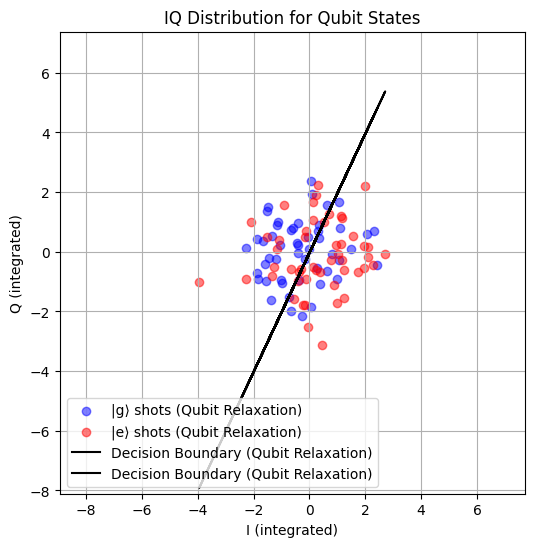

In [133]:
optimal_start_time = int(res.result.xbest[0])
optimal_end_time = int(res.result.xbest[1])

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(min(Q_g + Q_e) - 5,max(Q_g + Q_e) + 5)
plt.xlim(min(I_g + I_e) - 5,max(I_g + I_e) + 5)
plt.show()

In [134]:
result_g = qload('result_g_decay')
result_e = qload('result_e_decay')

In [135]:
# === Your Cost Function ===
def readout_cost(params):
    fidelity, snr = readout_fidelity(*params)
    print(f"Params: {params} → Fiedlity: {fidelity}, SNR: {snr}")
    return -fidelity

# === Parameter Bounds ===
bounds = [(1, 7999),      # Integration start time
          (2, 8000),      # Integration end time
          ]

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(readout_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best integration times:", res.result.xbest)
print("Best readout fidelity:", -res.result.fbest)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=931228, Fri Jun 13 06:33:06 2025)
Params: [3707.28250508 4178.5150763 ] → Fiedlity: 0.54, SNR: 0.02575279504284891
Params: [4186.93720863 4462.65657125] → Fiedlity: 0.46, SNR: 0.002145815750701934
Params: [3848.39990134 3713.99800375] → Fiedlity: -inf, SNR: -inf
Params: [3867.13487347 4044.85869587] → Fiedlity: 0.55, SNR: 0.06550592334018722
Params: [4683.61829492 4122.85373353] → Fiedlity: -inf, SNR: -inf
Params: [3892.26581391 4195.27426667] → Fiedlity: 0.46, SNR: 0.006771637268141378
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -5.500000000000000e-01 1.0e+00 2.81e-01  2e+02  2e+02 0:00.0
Params: [3917.06382999 4095.81414735] → Fiedlity: 0.53, SNR: 0.07175438361958648
Params: [4084.60999744 3987.345468  ] → Fiedlity: -inf, SNR: -inf
Params: [3587.38935717 3652.45807582] → Fiedlity: 0.57, SNR: 0.20325600726548293
Params: [3798.87322952 4666.70344925] → Fiedlity: 0.52, SNR: 0.010859971632287

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [2, 4] are not finite but [inf, inf]. (time=Jun 13 06:33:06 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 4] are not finite but [inf, inf]. (time=Jun 13 06:33:06 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 3] are not finite but [inf, inf]. (time=Jun 13 06:33:06 2025 class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 5] are not finite but [inf, inf]. (time

Params: [1599.57205076 2868.08575391] → Fiedlity: 0.59, SNR: 0.1826087136562244
Params: [ 881.65443797 3505.75348928] → Fiedlity: 0.68, SNR: 0.2989717922226514
Params: [1345.42017    4137.87014411] → Fiedlity: 0.62, SNR: 0.10941676181161654
Params: [1134.4461085 2753.1825088] → Fiedlity: 0.61, SNR: 0.1827491153649445
Params: [2290.94290646 3195.28642575] → Fiedlity: 0.57, SNR: 0.060173251716227255
Params: [1389.69917356 2922.81986966] → Fiedlity: 0.59, SNR: 0.1372422019974983
   10     60 -6.800000000000000e-01 1.9e+00 6.77e-01  3e+02  6e+02 0:00.2
Params: [ 824.67362778 4003.3527423 ] → Fiedlity: 0.66, SNR: 0.19284507765181144
Params: [ 158.56330682 3309.14931219] → Fiedlity: 0.63, SNR: 0.3031887983447542
Params: [ 740.24474487 3588.32325509] → Fiedlity: 0.62, SNR: 0.22485919435425866
Params: [1081.16154248 3936.51865732] → Fiedlity: 0.62, SNR: 0.10564380424144146
Params: [1579.72058302 3580.81402521] → Fiedlity: 0.59, SNR: 0.16356306929723796
Params: [1180.25695231 4052.97341627] → F

Readout fidelity (Qubit Relaxation): 0.7000
SNR of readout: 0.29


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


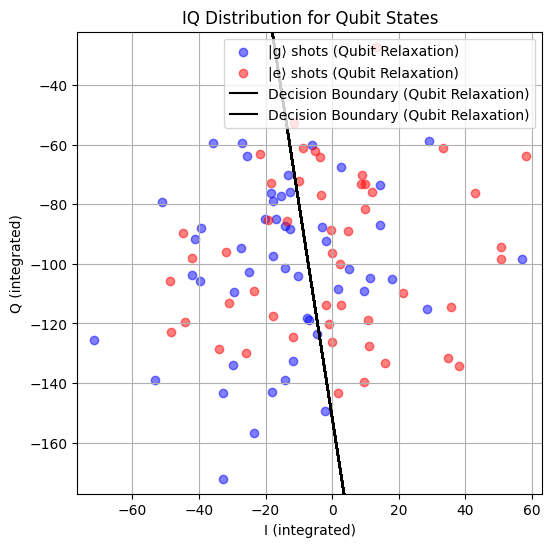

In [136]:
optimal_start_time = int(res.result.xbest[0])
optimal_end_time = int(res.result.xbest[1])

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, optimal_start_time:optimal_end_time]
    Q = m[0, 1, optimal_start_time:optimal_end_time]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(min(Q_g + Q_e) - 5,max(Q_g + Q_e) + 5)
plt.xlim(min(I_g + I_e) - 5,max(I_g + I_e) + 5)
plt.show()

In [137]:
# Define circuit parameters

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001 * 2 * np.pi   # Qubit decay (0.1 MHz) [self-defined, not from reference]
gamma_2 = 0.001 * 2 * np.pi   # Qubit dephase (0.1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
H0 = (wr - wd + chi * sz) * a.dag() * a + (wq -wd)/2 * sz
drive_power = 4.984375000000001e-05 * 2 * np.pi

c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns

# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 11.58332303322993
ringdown1_norm = 1.6156046841062026
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 12.242809267406063
drive_norm = 2.0615066563271975
ringdown2_norm = 14.632117912321677
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 47.6257865352412
optimal_ringdown1_time = 90.36540617777688
optimal_ringup2_time = 20.668371079660396
optimal_ringdown2_time = 44.48693108893437


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]


In [138]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-3, window_size=500):
    photon_number = np.array(photon_number)
    tlist = np.array(tlist)

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]

    return None

def find_cavity_reset_time(tlist, photon_number, threshold=1e-3, stable_time=50):
    offset = 5000
    photon_number = np.array(photon_number[offset:])
    tlist = np.array(tlist[offset:])

    dt = tlist[1] - tlist[0]
    stable_points = int(np.ceil(stable_time / dt))

    below = photon_number <= threshold

    i = 0
    while i <= len(below) - stable_points:
        if below[i]:
            window = below[i : i + stable_points]
            if np.all(window):
                return tlist[i] - 500  # Adjust based on original intent
            else:
                # Skip ahead to end of unstable segment
                first_fail = np.argmax(~window)  # Index of first False in the window
                i += first_fail + 1  # Move to next candidate index
        else:
            i += 1  # Keep scanning

    return np.inf  # No stable period found

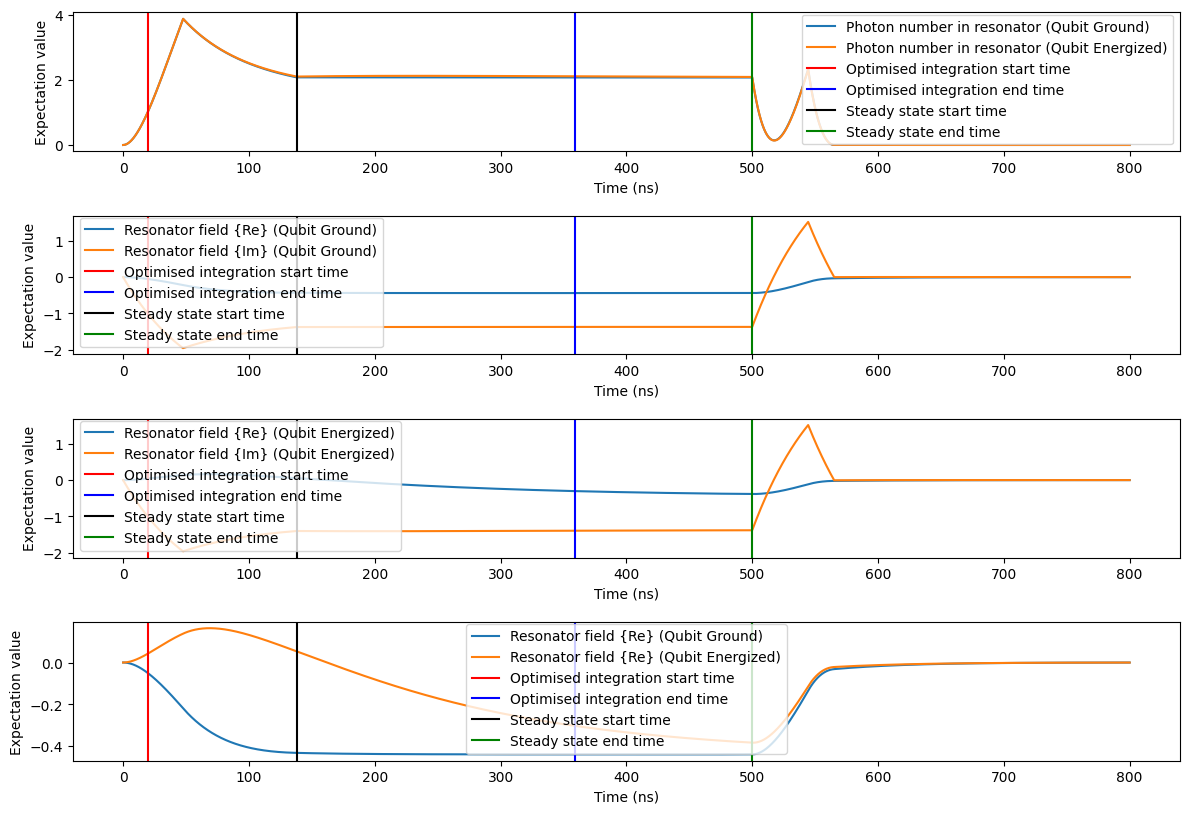

In [139]:
expectations_g = mesolve(H_CLEAR, psi0, tlist, c_ops)
expectations_e = mesolve(H_CLEAR, psi1, tlist, c_ops)

# Extract the expectation values
expectation_values_g = expect(e_ops,expectations_g.states)
expectation_values_e = expect(e_ops,expectations_e.states)

steady_state_time = find_steady_state_time(tlist, expectation_values_g[0])
reset_time = find_cavity_reset_time(tlist, expectation_values_g[0]) / 100

# Plot the results
plt.figure(figsize=(12, 18))

plt.subplot(9, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.axvline(x=optimal_start_time/ 10, label='Optimised integration start time', color='red')
plt.axvline(x=optimal_end_time/ 10, label='Optimised integration end time', color='blue')
plt.axvline(x=steady_state_time, label='Steady state start time', color='black')
plt.axvline(x=500, label='Steady state end time', color='green')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.axvline(x=optimal_start_time/ 10, label='Optimised integration start time', color='red')
plt.axvline(x=optimal_end_time/ 10, label='Optimised integration end time', color='blue')
plt.axvline(x=steady_state_time, label='Steady state start time', color='black')
plt.axvline(x=500, label='Steady state end time', color='green')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 3)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.axvline(x=optimal_start_time/ 10, label='Optimised integration start time', color='red')
plt.axvline(x=optimal_end_time/ 10, label='Optimised integration end time', color='blue')
plt.axvline(x=steady_state_time, label='Steady state start time', color='black')
plt.axvline(x=500, label='Steady state end time', color='green')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 4)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.axvline(x=optimal_start_time/ 10, label='Optimised integration start time', color='red')
plt.axvline(x=optimal_end_time/ 10, label='Optimised integration end time', color='blue')
plt.axvline(x=steady_state_time, label='Steady state start time', color='black')
plt.axvline(x=500, label='Steady state end time', color='green')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()


plt.tight_layout()
plt.show()